In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/OpenMP_9.csv")


In [2]:
df = pd.read_csv(resultsPath)
df["matrixSize"] = df["matrixSize"].astype(int)
df["numThreads"] = df["numThreads"].astype(int)
df["innerThreads"] = df["innerThreads"].astype(int)
df["timeSeconds"] = df["timeSeconds"].astype(float)
df["runIndex"] = df["runIndex"].astype(int)

print("Loaded rows:", len(df))
print("Modes:", df["mode"].unique())
print("matrixSizes:", sorted(df["matrixSize"].unique()))
print("numThreads:", sorted(df["numThreads"].unique()))
print("innerThreads:", sorted(df["innerThreads"].unique()))
df.head(8)


Loaded rows: 810
Modes: ['outer' 'inner' 'nested']
matrixSizes: [500, 1000, 2000]
numThreads: [1, 2, 4, 6, 8, 16]
innerThreads: [1, 2, 4]


,testType,matrixSize,numThreads,mode,innerThreads,timeSeconds,maxOfRowMins,runIndex,ompEnv
0,OpenMP_9,500,1,outer,1,0.000123,18987.50,1,OMP_NUM_THREADS=1
1,OpenMP_9,500,1,outer,1,0.000118,9493.20,2,OMP_NUM_THREADS=1
2,OpenMP_9,500,1,outer,1,0.000118,9727.37,3,OMP_NUM_THREADS=1
3,OpenMP_9,500,1,outer,1,0.000146,12726.40,4,OMP_NUM_THREADS=1
4,OpenMP_9,500,1,outer,1,0.000118,12617.40,5,OMP_NUM_THREADS=1
5,OpenMP_9,500,1,outer,2,0.000119,14466.70,1,OMP_NUM_THREADS=1
6,OpenMP_9,500,1,outer,2,0.000117,10960.50,2,OMP_NUM_THREADS=1
7,OpenMP_9,500,1,outer,2,0.000119,21369.40,3,OMP_NUM_THREADS=1


In [3]:
grouped = df.groupby(["mode","matrixSize","innerThreads","numThreads"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
grouped["std"] = grouped["std"].fillna(0.0)
grouped = grouped.sort_values(["mode","matrixSize","innerThreads","numThreads"]).reset_index(drop=True)
grouped.head(12)


,mode,matrixSize,innerThreads,numThreads,median,mean,std,count
0,inner,500,1,1,0.001935,0.002025,0.000622,5
1,inner,500,1,2,0.010654,0.010653,0.000320,5
2,inner,500,1,4,0.014378,0.014137,0.000513,5
3,inner,500,1,6,0.016446,0.016401,0.000337,5
4,inner,500,1,8,0.019517,0.019330,0.000382,5
5,inner,500,1,16,0.031722,0.031656,0.000237,5
6,inner,500,2,1,0.001512,0.001595,0.000175,5
7,inner,500,2,2,0.011047,0.011152,0.000806,5
8,inner,500,2,4,0.014121,0.014073,0.000229,5
9,inner,500,2,6,0.016633,0.016653,0.000440,5


In [4]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    groupKeys = ["mode","matrixSize","innerThreads"]
    for keys, sub in groupedDf.groupby(groupKeys):
        baseRows = sub[(sub["numThreads"] == 1) & (sub["innerThreads"] == sub["innerThreads"].min())]
        baseRows = sub[sub["numThreads"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        sf = sub.copy()
        sf["speedup"] = baseTime / sf["median"]
        sf["efficiency"] = sf["speedup"] / sf["numThreads"]
        frames.append(sf)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(grouped)
perfFrame.head(12)


,mode,matrixSize,innerThreads,numThreads,median,mean,std,count,speedup,efficiency
0,inner,500,1,1,0.001935,0.002025,0.000622,5,1.000000,1.000000
1,inner,500,1,2,0.010654,0.010653,0.000320,5,0.181636,0.090818
2,inner,500,1,4,0.014378,0.014137,0.000513,5,0.134592,0.033648
3,inner,500,1,6,0.016446,0.016401,0.000337,5,0.117671,0.019612
4,inner,500,1,8,0.019517,0.019330,0.000382,5,0.099156,0.012395
5,inner,500,1,16,0.031722,0.031656,0.000237,5,0.061004,0.003813
6,inner,500,2,1,0.001512,0.001595,0.000175,5,1.000000,1.000000
7,inner,500,2,2,0.011047,0.011152,0.000806,5,0.136823,0.068412
8,inner,500,2,4,0.014121,0.014073,0.000229,5,0.107038,0.026759
9,inner,500,2,6,0.016633,0.016653,0.000440,5,0.090874,0.015146


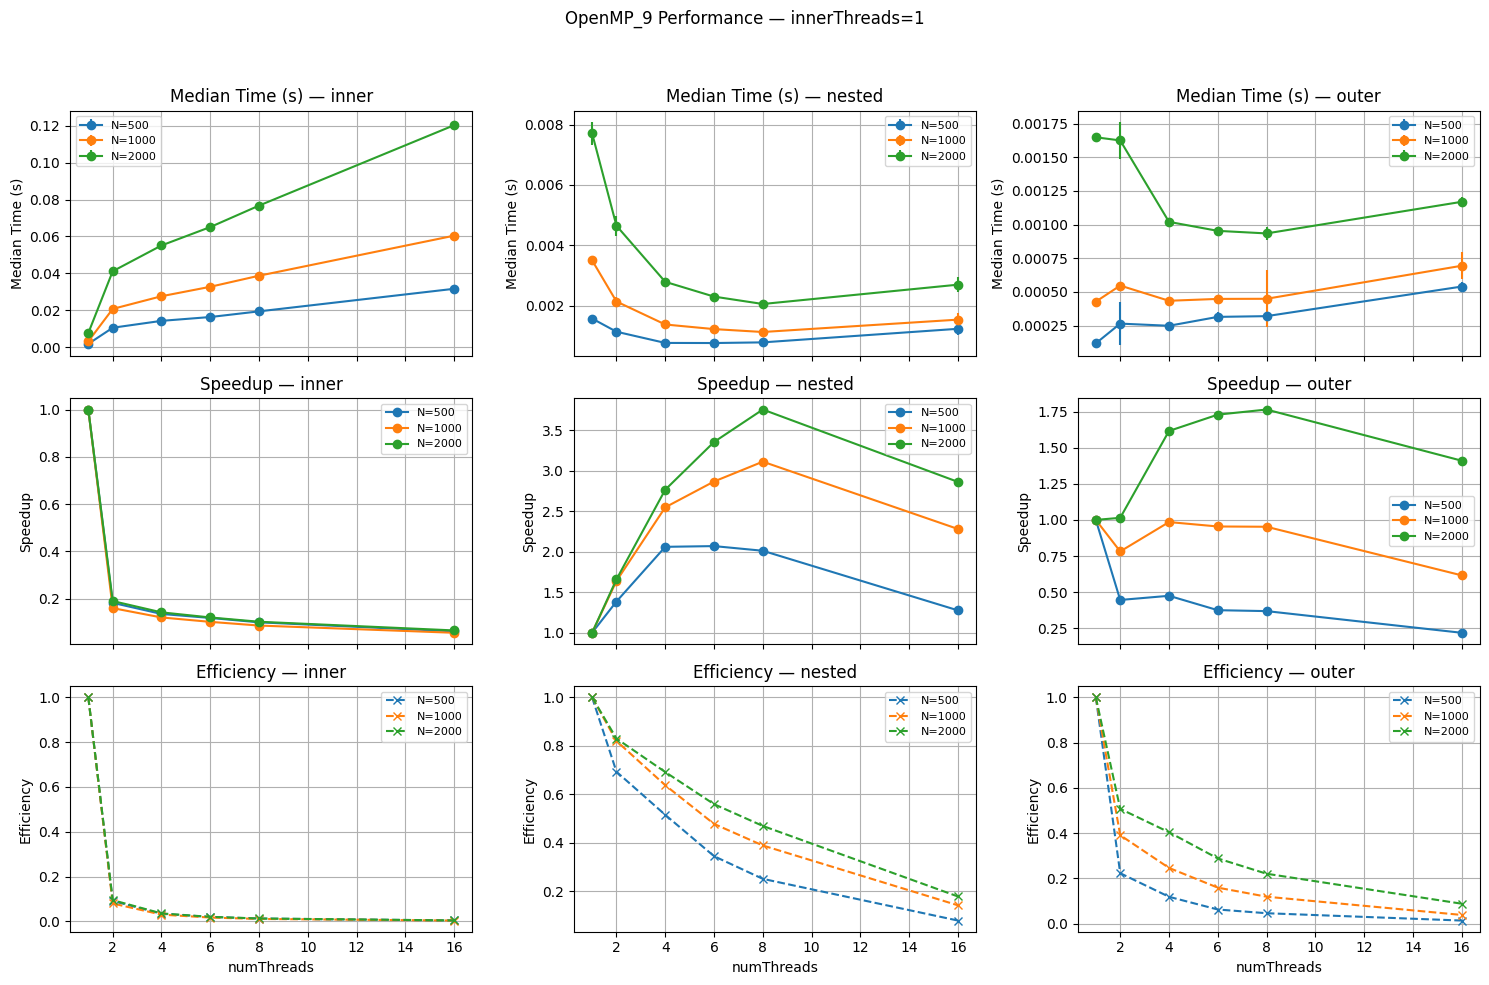

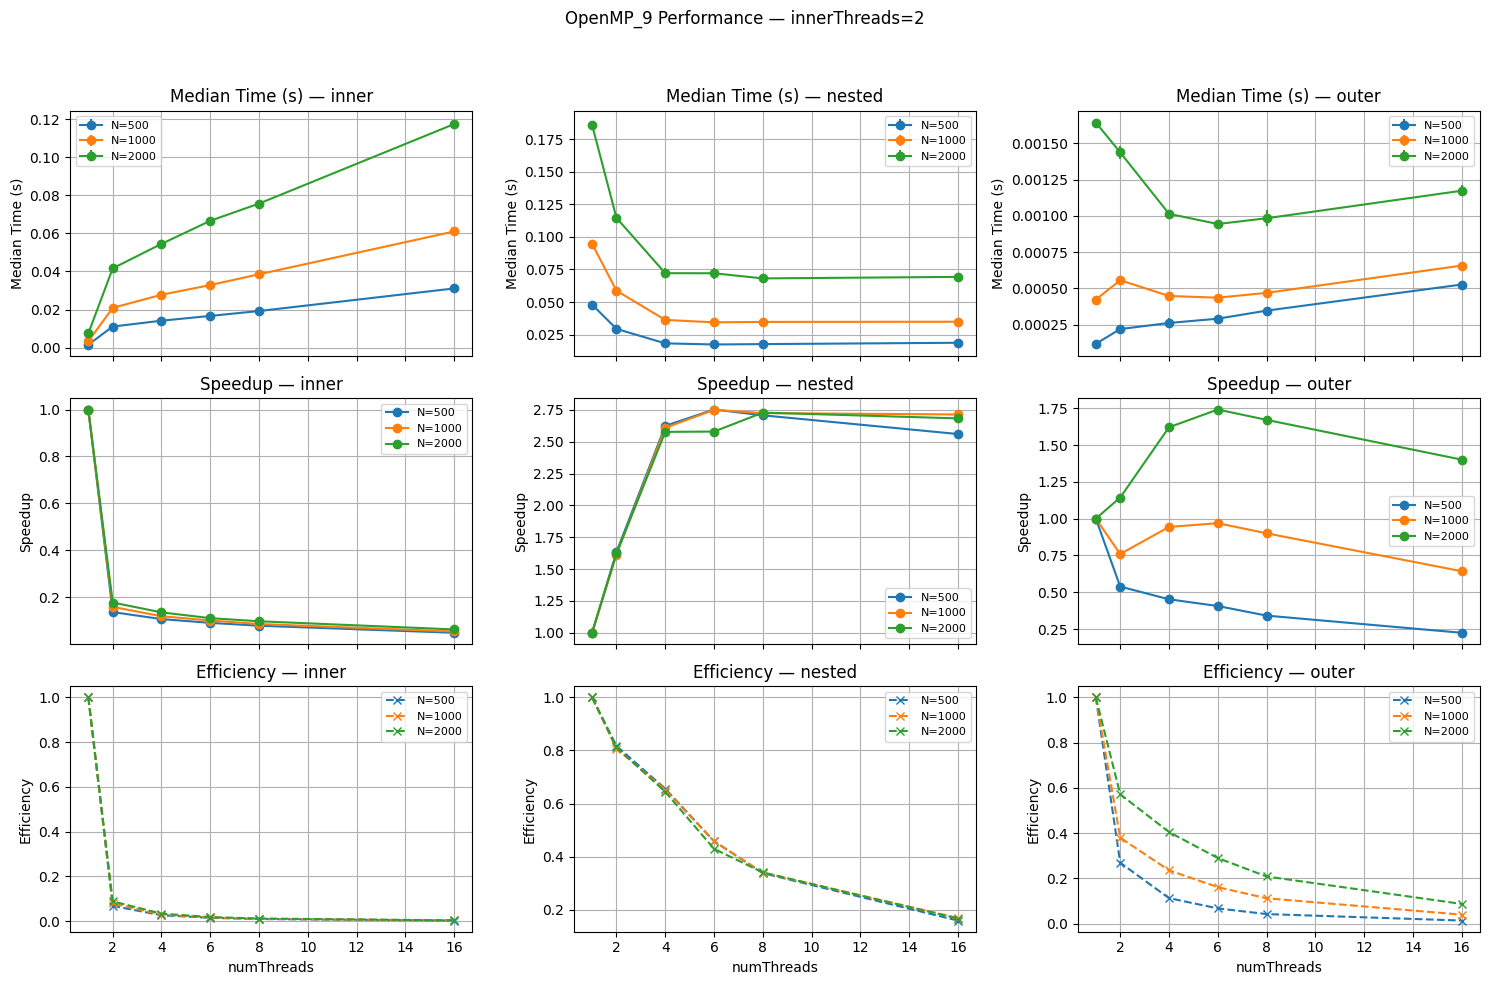

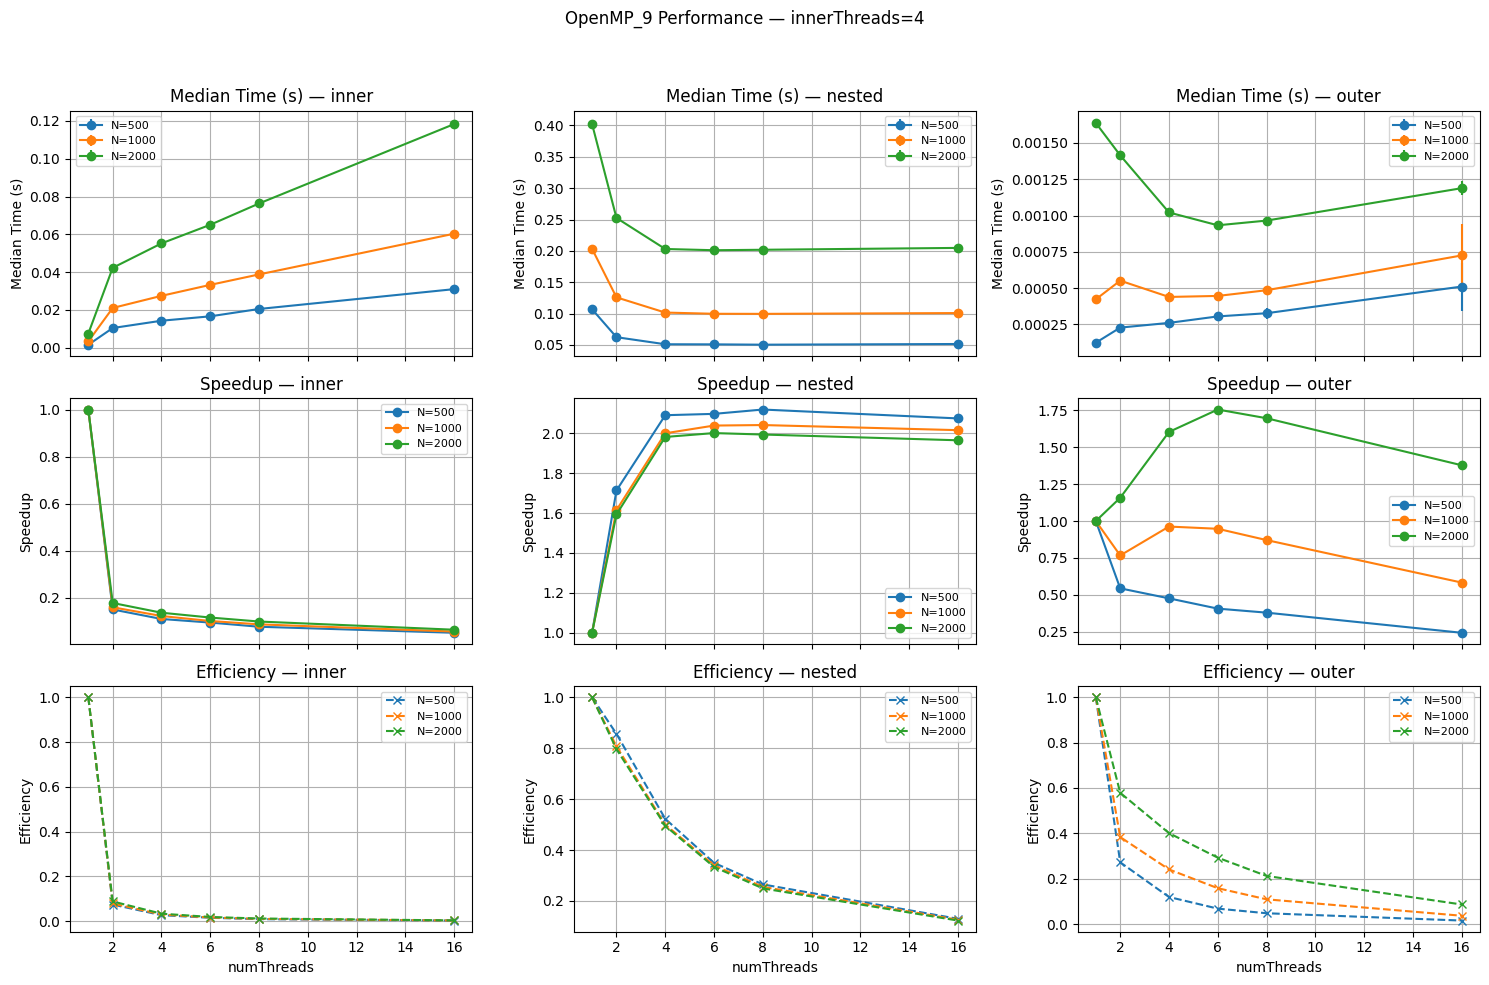

In [5]:
metrics = ["median","speedup","efficiency"]
metricLabels = {"median":"Median Time (s)", "speedup":"Speedup", "efficiency":"Efficiency"}

modes = sorted(perfFrame["mode"].unique())
matrixSizeList = sorted(perfFrame["matrixSize"].unique())
innerThreadsList = sorted(perfFrame["innerThreads"].unique())

for innerThreadsVal in innerThreadsList:
    filterByInner = perfFrame[perfFrame["innerThreads"] == innerThreadsVal]
    if filterByInner.empty:
        print(f"No data for innerThreads={innerThreadsVal}")
        continue

    numCols = max(1, len(modes))
    fig, axes = plt.subplots(len(metrics), numCols, figsize=(5 * numCols, 10), sharex=True)
    if len(metrics) == 1 and numCols == 1:
        axes2d = np.array([[axes]])
    elif len(metrics) == 1:
        axes2d = np.array([axes])
    elif numCols == 1:
        axes2d = np.array([[ax] for ax in axes])
    else:
        axes2d = axes

    for colIdx, modeVal in enumerate(modes):
        for rowIdx, metric in enumerate(metrics):
            ax = axes2d[rowIdx][colIdx]
            subForMode = filterByInner[filterByInner["mode"] == modeVal]
            if subForMode.empty:
                ax.text(0.5, 0.5, 'no data', ha='center', va='center')
                ax.set_title(f"{modeVal}")
                ax.grid(True)
                continue

            for matrixSizeVal in matrixSizeList:
                subFrame = subForMode[subForMode["matrixSize"] == matrixSizeVal].sort_values("numThreads")
                if subFrame.empty:
                    continue
                x = subFrame["numThreads"].values
                y = subFrame[metric].values
                if metric == "median":
                    yerr = subFrame["std"].values
                    ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"N={matrixSizeVal}")
                else:
                    linestyle = '-' if metric == 'speedup' else '--'
                    markerStyle = 'o' if metric == 'speedup' else 'x'
                    ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"N={matrixSizeVal}")

            ax.set_title(f"{metricLabels[metric]} — {modeVal}")
            if rowIdx == len(metrics) - 1:
                ax.set_xlabel('numThreads')
            ax.set_ylabel(metricLabels[metric])
            ax.grid(True)
            ax.legend(fontsize=8)

    plt.suptitle(f'OpenMP_9 Performance — innerThreads={innerThreadsVal}')
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


In [8]:
for modeVal in perfFrame["mode"].unique():
    sample = perfFrame[perfFrame["mode"] == modeVal]
    print(f"\n=== mode: {modeVal} — median time (s) ===")
    display(sample.pivot_table(index=["numThreads","innerThreads"], columns="matrixSize", values="median"))
    print(f"\n=== mode: {modeVal} — speedup ===")
    display(sample.pivot_table(index=["numThreads","innerThreads"], columns="matrixSize", values="speedup"))



=== mode: inner — median time (s) ===


matrixSize                   500       1000      2000
numThreads innerThreads                              
1          1             0.001935  0.003318  0.007798
           2             0.001512  0.003312  0.007393
           4             0.001554  0.003335  0.007481
2          1             0.010654  0.020832  0.041212
           2             0.011047  0.020868  0.041639
           4             0.010406  0.021022  0.042277
4          1             0.014378  0.027695  0.055156
           2             0.014121  0.027753  0.054491
           4             0.014272  0.027443  0.055204
6          1             0.016446  0.032801  0.065106
           2             0.016633  0.032847  0.066630
           4             0.016604  0.033252  0.065060
8          1             0.019517  0.038788  0.076714
           2             0.019203  0.038525  0.075685
           4             0.020488  0.038780  0.076326
16         1             0.031722  0.060449  0.120191
           2             0.031075  0.061039  0.117473
           4             0.030990  0.060332  0.118359


=== mode: inner — speedup ===


matrixSize                   500       1000      2000
numThreads innerThreads                              
1          1             1.000000  1.000000  1.000000
           2             1.000000  1.000000  1.000000
           4             1.000000  1.000000  1.000000
2          1             0.181636  0.159268  0.189209
           2             0.136823  0.158714  0.177563
           4             0.149337  0.158641  0.176954
4          1             0.134592  0.119798  0.141375
           2             0.107038  0.119342  0.135682
           4             0.108886  0.121519  0.135518
6          1             0.117671  0.101148  0.119767
           2             0.090874  0.100835  0.110964
           4             0.093594  0.100292  0.114988
8          1             0.099156  0.085536  0.101645
           2             0.078714  0.085974  0.097687
           4             0.075848  0.085995  0.098015
16         1             0.061004  0.054886  0.064877
           2             0.048640  0.054262  0.062938
           4             0.050146  0.055276  0.063207


=== mode: nested — median time (s) ===


matrixSize                   500       1000      2000
numThreads innerThreads                              
1          1             0.001571  0.003501  0.007713
           2             0.048085  0.094751  0.185967
           4             0.106980  0.203288  0.402172
2          1             0.001133  0.002135  0.004646
           2             0.029432  0.058741  0.114587
           4             0.062455  0.125931  0.252497
4          1             0.000762  0.001373  0.002787
           2             0.018324  0.036318  0.072167
           4             0.051188  0.101675  0.203013
6          1             0.000759  0.001220  0.002298
           2             0.017471  0.034459  0.072098
           4             0.051023  0.099743  0.201039
8          1             0.000780  0.001124  0.002052
           2             0.017764  0.034781  0.068169
           4             0.050501  0.099617  0.201774
16         1             0.001230  0.001534  0.002693
           2             0.018783  0.034918  0.069319
           4             0.051585  0.100884  0.204738


=== mode: nested — speedup ===


matrixSize                   500       1000      2000
numThreads innerThreads                              
1          1             1.000000  1.000000  1.000000
           2             1.000000  1.000000  1.000000
           4             1.000000  1.000000  1.000000
2          1             1.386428  1.640073  1.660174
           2             1.633739  1.613038  1.622933
           4             1.712924  1.614281  1.592779
4          1             2.062082  2.550189  2.767771
           2             2.624181  2.608907  2.576912
           4             2.089943  1.999390  1.981016
6          1             2.071052  2.869120  3.357199
           2             2.752242  2.749636  2.579361
           4             2.096701  2.038110  2.000468
8          1             2.013456  3.114126  3.758283
           2             2.706923  2.724188  2.728045
           4             2.118391  2.040700  1.993180
16         1             1.276902  2.282501  2.864278
           2             2.560012  2.713508  2.682767
           4             2.073875  2.015067  1.964325


=== mode: outer — median time (s) ===


matrixSize                   500       1000      2000
numThreads innerThreads                              
1          1             0.000118  0.000428  0.001649
           2             0.000119  0.000423  0.001643
           4             0.000124  0.000423  0.001637
2          1             0.000265  0.000547  0.001625
           2             0.000220  0.000556  0.001437
           4             0.000228  0.000552  0.001414
4          1             0.000249  0.000434  0.001020
           2             0.000262  0.000448  0.001014
           4             0.000261  0.000440  0.001021
6          1             0.000315  0.000448  0.000954
           2             0.000291  0.000436  0.000944
           4             0.000305  0.000447  0.000933
8          1             0.000320  0.000449  0.000935
           2             0.000347  0.000469  0.000983
           4             0.000327  0.000486  0.000965
16         1             0.000540  0.000694  0.001169
           2             0.000527  0.000657  0.001173
           4             0.000511  0.000725  0.001188


=== mode: outer — speedup ===


matrixSize                   500       1000      2000
numThreads innerThreads                              
1          1             1.000000  1.000000  1.000000
           2             1.000000  1.000000  1.000000
           4             1.000000  1.000000  1.000000
2          1             0.445788  0.781798  1.014399
           2             0.538846  0.759885  1.143454
           4             0.544221  0.767041  1.157593
4          1             0.474658  0.985033  1.615701
           2             0.452499  0.943750  1.620438
           4             0.476428  0.962685  1.603624
6          1             0.374960  0.954485  1.728712
           2             0.406861  0.969280  1.740807
           4             0.406874  0.947592  1.755253
8          1             0.368635  0.952572  1.764045
           2             0.341787  0.900532  1.670701
           4             0.379658  0.871114  1.696332
16         1             0.218559  0.616071  1.409818
           2             0.225133  0.643237  1.400631
           4             0.243249  0.583345  1.377851

In [12]:
summaryRows = []
for (modeVal, matrixSizeVal, innerThreadsVal), sub in perfFrame.groupby(["mode","matrixSize", "innerThreads"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestThreads = int(argMax["numThreads"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numThreads"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "matrixSize": matrixSizeVal,
        "innerThreads": innerThreadsVal,
        "bestNumThreads": bestThreads,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Thread": medianAtOne
    })
summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["mode","matrixSize", "innerThreads"])
display(summaryAnalysisFrame)


,mode,matrixSize,innerThreads,bestNumThreads,maxSpeedup,efficiencyAtBest,medianTime1Thread
0,inner,500,1,1,1.000000,1.000000,0.001935
1,inner,500,2,1,1.000000,1.000000,0.001512
2,inner,500,4,1,1.000000,1.000000,0.001554
3,inner,1000,1,1,1.000000,1.000000,0.003318
4,inner,1000,2,1,1.000000,1.000000,0.003312
5,inner,1000,4,1,1.000000,1.000000,0.003335
6,inner,2000,1,1,1.000000,1.000000,0.007798
7,inner,2000,2,1,1.000000,1.000000,0.007393
8,inner,2000,4,1,1.000000,1.000000,0.007481
9,nested,500,1,6,2.071052,0.345175,0.001571
